# Market Predictions Using LSTM Network

Spencer Bertsch <br> 
Dartmouth College, Winter 2019

Data Sources: <br>
https://www.kaggle.com/camnugent/sandp500/version/4#all_stocks_5yr.csv

The main source for this notebook was [Soumith's Githib - Time Sequence Prediction](https://github.com/pytorch/examples/tree/master/time_sequence_prediction) in which he goes through the problem of using a recurrent neural network to predict a sine wave. 

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cycler
import time 
import pandas as pd
import time

from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

import datetime as dt 
from matplotlib import style
import pandas_datareader.data as web

#Plotting 
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import cm

import matplotlib.dates as mdates

# Import and Prepare Data 
------

In [2]:
#Load .csv file
path = '/Users/spencerbertsch/Desktop/ENGG_192/RNNs/Data/AAPL.csv'
path2 = '/Users/spencerbertsch/Desktop/ENGG_192/RNNs/Data/all_stocks_5yr.csv'
#create a data frame from the data stored in the .csv file
df = pd.read_csv(path)
SP500_data = pd.read_csv(path2)
SP500 = SP500_data.values

print("We have 500 stocks in our training dataset and a total daily closing values of: ", SP500.shape[0])
print("Which gives us", (SP500.shape[0])/505, "data points per stock")
SP500_data.head(5)

We have 500 stocks in our training dataset and a total daily closing values of:  635795
Which gives us 1259.0 data points per stock


,date,open,high,low,close,volume,Name
0,2/8/13,15.07,15.12,14.63,14.75,8407500,AAL
1,2/11/13,14.89,15.01,14.26,14.46,8882000,AAL
2,2/12/13,14.45,14.51,14.10,14.27,8126000,AAL
3,2/13/13,14.30,14.94,14.25,14.66,10259500,AAL
4,2/14/13,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
close_price = SP500[:, 4]
#price_mat = close_price.reshape(500, 1238)#1259
price_mat = close_price.reshape(505, 1259)#1259

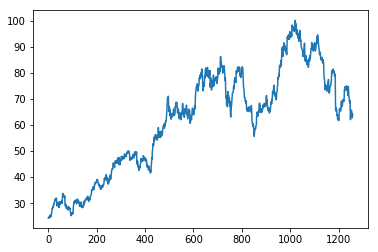

In [4]:
plt.plot(price_mat[26,:])

Only the first 26 stocks are the same length, which will not matter for training our RNN, but the stock price will jump inside our vectors if we go past 26 stock in our dataframe 

In [5]:
data = price_mat[:26,:]
data.astype(float)
data.shape

data2 = pd.DataFrame(data)

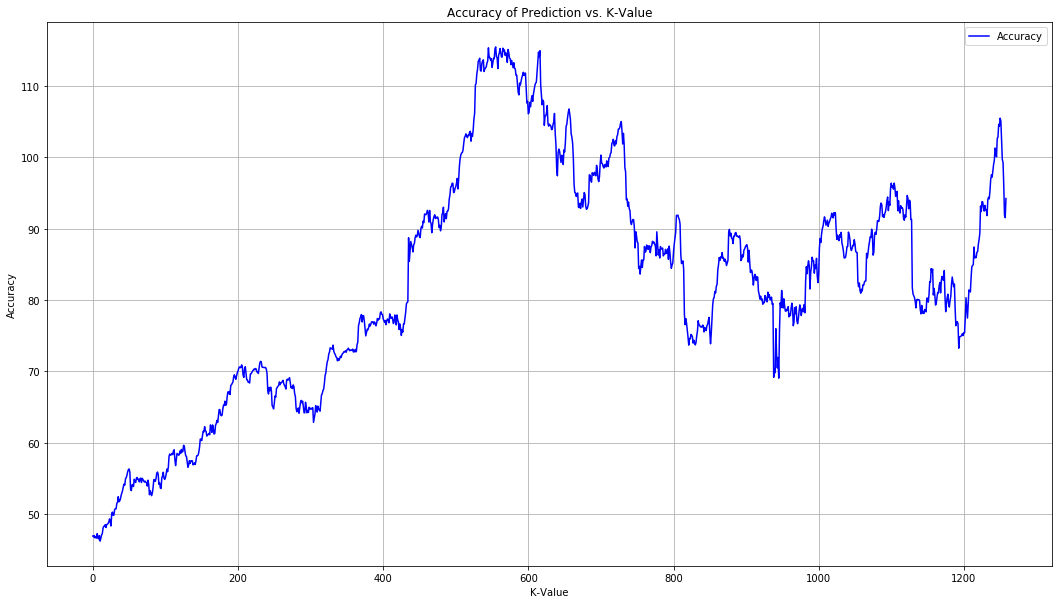

In [6]:
x = range(0,500)
y = range(0,1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

plt.plot(data[4,:], 'b', label='Accuracy')
plt.legend(loc='upper right');
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.title('Accuracy of Prediction vs. K-Value')
plt.grid() 

In [7]:
#calculate and store averages for window sizes of 25, 50, 100, and 200
W25 = data2.iloc[4,:].rolling(window=25,min_periods=0).mean()
W50 = data2.iloc[4,:].rolling(window=50,min_periods=0).mean()
W100 = data2.iloc[4,:].rolling(window=100,min_periods=0).mean()
W200 = data2.iloc[4,:].rolling(window=200,min_periods=0).mean()

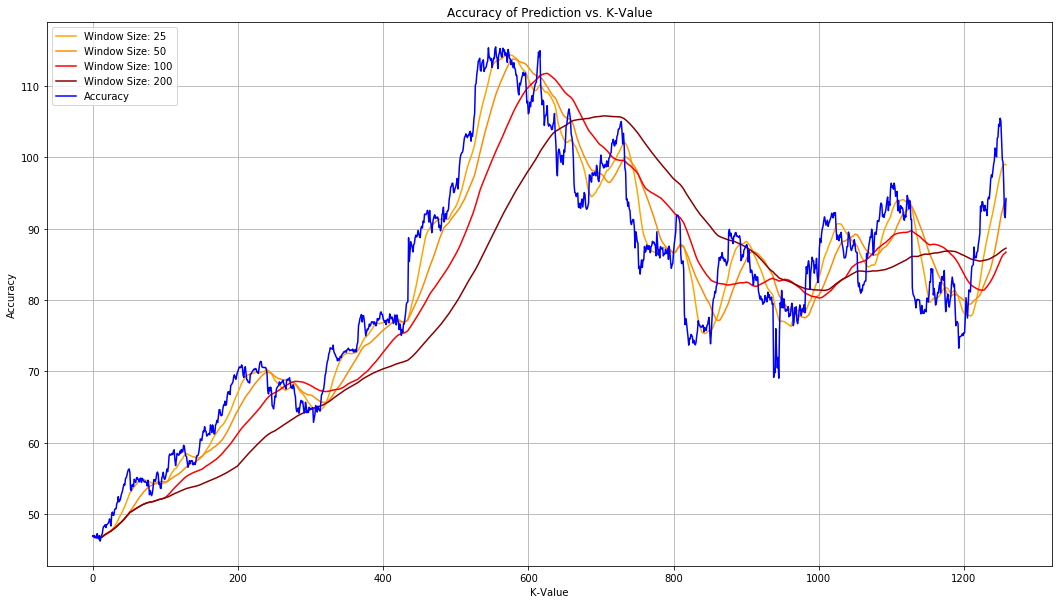

In [8]:
x = range(0,500)
y = range(0,1)
fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(111)

ax1.plot(data2.iloc[4,:].index, W25, color='orange', label=('Window Size: 25'))
ax1.plot(data2.iloc[4,:].index, W50, color='darkorange', label=('Window Size: 50'))
ax1.plot(data2.iloc[4,:].index, W100, color='red', label=('Window Size: 100'))
ax1.plot(data2.iloc[4,:].index, W200, color='darkred', label=('Window Size: 200'))
plt.plot(data2.iloc[4,:], 'b', label='Accuracy')
plt.legend(loc='upper left');
plt.xlabel('K-Value')
plt.ylabel('Accuracy')
plt.title('Accuracy of Prediction vs. K-Value')
plt.grid() 

# Define Sequence Class

In [13]:
units = 250

class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, units)
        self.lstm2 = nn.LSTMCell(units, units)
        self.linear = nn.Linear(units, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = torch.zeros(input.size(0), units, dtype=torch.double)
        c_t = torch.zeros(input.size(0), units, dtype=torch.double)
        h_t2 = torch.zeros(input.size(0), units, dtype=torch.double)
        c_t2 = torch.zeros(input.size(0), units, dtype=torch.double)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs += [output]
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [14]:
# set random seed to 0
np.random.seed(0)
torch.manual_seed(0)
# load data and make training set



In [15]:
#Prepare data
input = torch.from_numpy(((data[3:, :-1]).astype(float)))
target = torch.from_numpy(((data[3:, 1:]).astype(float)))
test_input = torch.from_numpy(((data[:3, :-1]).astype(float)))
test_target = torch.from_numpy(((data[:3, 1:]).astype(float)))

In [16]:
# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters(), lr=0.8)
#begin to train

STEP:  0
loss: 9486.528263480437
loss: 9482.83061351471
loss: 9421.540069632143
loss: 9108.092889449721
loss: 7421.409650314014
loss: 103326.08889232251
loss: 6716.022359862791
loss: 3290.2724751265027
loss: 3242.2840141687034
loss: 3209.2095759993545
loss: 3204.5677657989922
loss: 3188.638202762123
loss: 3158.2530007777254
loss: 3138.7885602358406
loss: 3134.0050743616594
loss: 3119.9074969453204
loss: 3119.722276407932
loss: 3100.1016205054375
loss: 3083.4857338203756
loss: 3094.677457519934
test loss: 2608.806869879556
STEP:  1
loss: 3167.919715750276
loss: 2607.2805894770154
loss: 2466.897360874054
loss: 1980.1187695957763
loss: 1282.9366675430642
loss: 981.366071734458
loss: 883.9363476544311
loss: 740.9950536672206
loss: 595.3078151803076
loss: 501.9678511231797
loss: 476.88602008944713
loss: 505.60466138515767
loss: 374.03119670159145
loss: 338.47528571883333
loss: 318.72074918099275
loss: 302.0269892265138
loss: 269.39137204796356
loss: 247.7981081791043
loss: 213.9064826162823

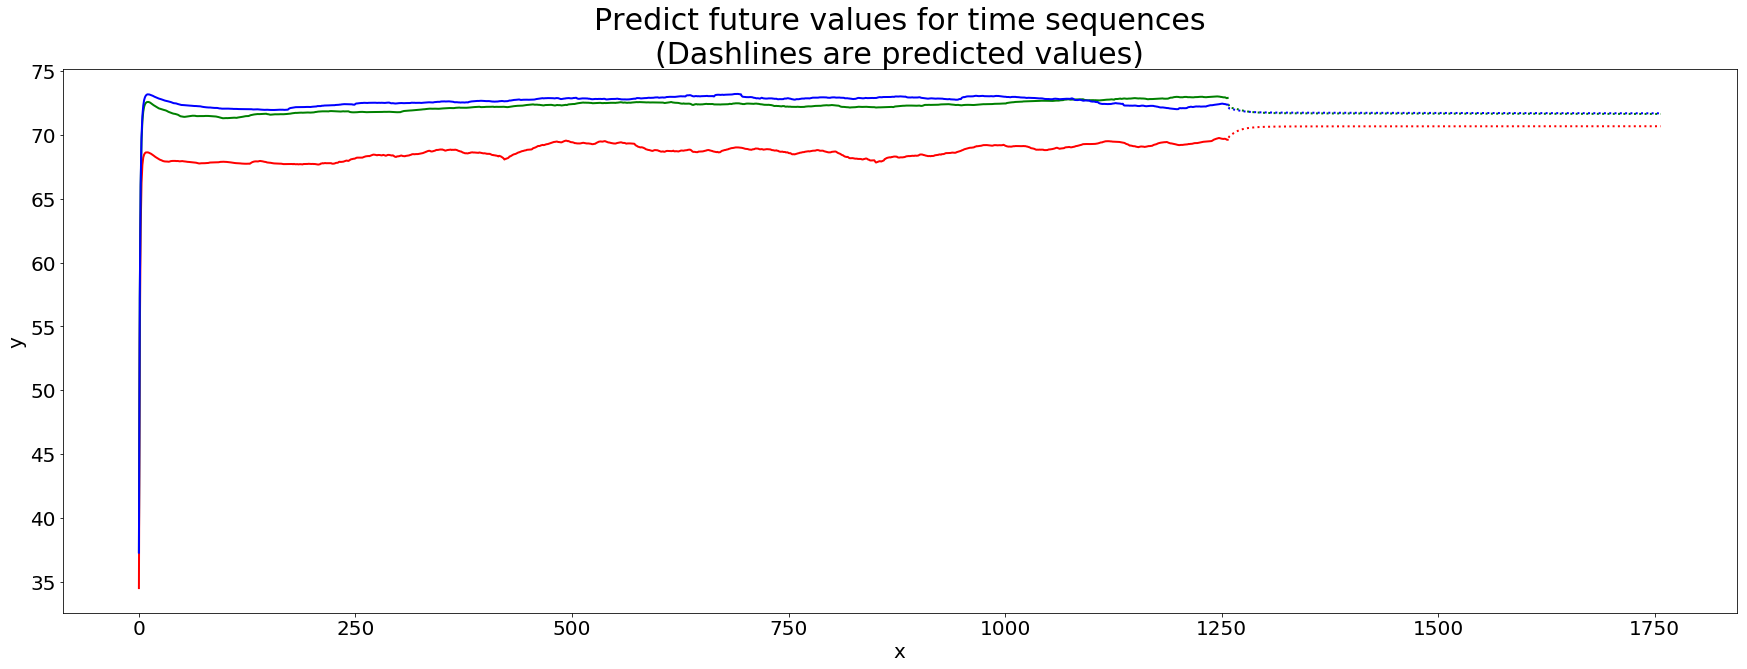

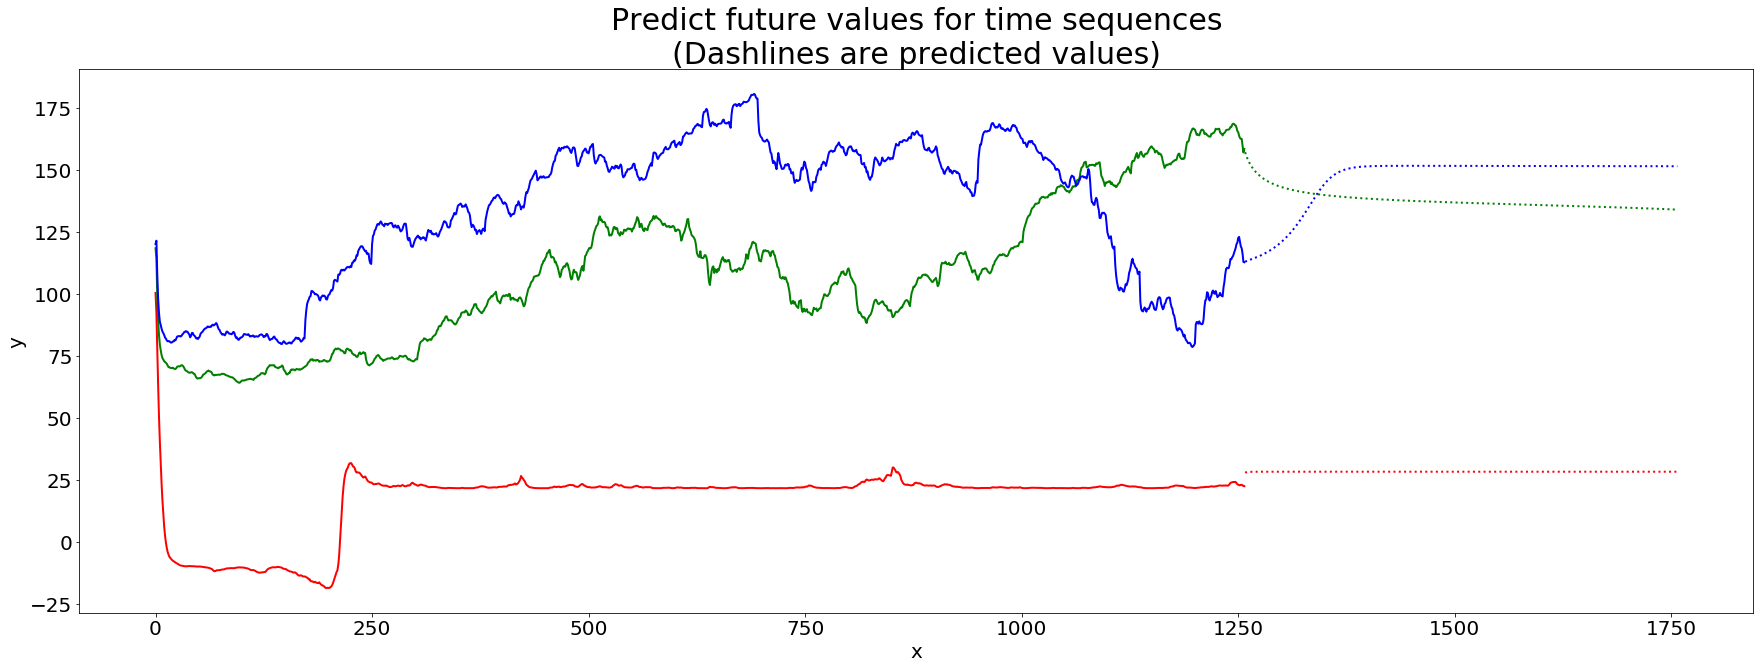

In [17]:
epochs = 5
tic = time.time()
for i in range(epochs):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(input)
        loss = criterion(out, target)
        print('loss:', loss.item())
        loss.backward()
        return loss
    optimizer.step(closure)
    # begin to predict, no need to track gradient here
    with torch.no_grad():
        future = 500
        pred = seq(test_input, future=future)
        loss = criterion(pred[:, :-future], test_target)
        print('test loss:', loss.item())
        y = pred.detach().numpy()
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future stock values\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('Day', fontsize=20)
    plt.ylabel('Stock Price (USD)', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    def draw(yi, color):
        plt.plot(np.arange(input.size(1)), yi[:input.size(1)], color, linewidth = 2.0)
        plt.plot(np.arange(input.size(1), input.size(1) + future), yi[input.size(1):], color + ':', linewidth = 2.0)
    draw(y[0], 'r')
    draw(y[1], 'g')
    draw(y[2], 'b')
    plt.savefig('predict%d.pdf'%i)
    #plt.close()
toc = time.time()

In [ ]:
train_time = toc - tic
secs = train_time%60
mins = (train_time - secs)/60

print('Time taken to train on', epochs, 'epochs was:', mins, 'minutes and', secs, 'seconds.')